In [76]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle
import multiprocessing
import seaborn as sns
import keras
import random
import arff

from sklearn import datasets
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# load data

In [39]:
def load_winequality_dataset():
    path_red_wine = "./wine_quality/winequality-red.csv"
    path_white_wine = "./wine_quality/winequality-white.csv"
    
    data_red = pd.read_csv(path_red_wine, delimiter=";")
    data_white = pd.read_csv(path_white_wine, delimiter=";")
    
    data = np.vstack((data_red, data_white))
    data_x, data_y = data[:, :-1], data[:,-1]
    
    return data_x, data_y


def load_credit_dataset():

    path = "./credit/credit.data"

    data = np.array(pd.read_csv(path, header=None, delimiter=","))

    data_list = []

    for index in range(data.shape[0]):
        row = [float(value) for value in data[index][0].split(" ") if value.isnumeric()]
        data_list.append(row)

    data_list = np.array(data_list)
    
    data_x = data_list[:, :-1]
    data_y = data_list[:, -1] -1
    
    return data_x, data_y


# segmentation dataset
def load_segmentation_dataset():
    path_train = "./segmentation/segmentation.data"
    path_test = "./segmentation/segmentation.test"

    data_train = np.array(pd.read_csv(path_train, header=None, delimiter=","))
    data_test = np.array(pd.read_csv(path_test, header=None, delimiter=","))

    data = np.vstack((data_train, data_test))
    data_y, data_x = data[:, 0], data[:, 1:]

    classes = np.unique(data_y)
    dic_str_to_int = dict(zip(classes, np.arange(0, len(classes), 1)))
    data_y = [dic_str_to_int[string] for string in data_y]

    return data_x, np.array(data_y)


def load_observatory_dataset():
    path = "./observatory/observatory.data"
    
    data = np.array(pd.read_csv(path_train, delimiter=","))
    data_y, data_x = data[:, -1], data[:, :-1]

    classes = np.unique(data_y)
    dic_str_to_int = dict(zip(classes, np.arange(0, len(classes), 1)))
    data_y = [dic_str_to_int[string] for string in data_y]
    
    return data_x, np.array(data_y)


def load_data(dataset):
    if dataset == "segmentation":
        data_x, data_y = load_segmentation_dataset()

    elif dataset == "credit":
        data_x, data_y = load_credit_dataset()
        
    elif dataset == "winequality":
        data_x, data_y = load_winequality_dataset()
        
    elif dataset == "observatory":
        data_x, data_y = load_observatory_dataset()

    return data_x, data_y


# aux functions

In [24]:
def k_fold_valifation_accuracy_rf(data_x, data_y, seed, num_fold=10):
    
    accuracy_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_indices, val_indices in kf.split(data_x):

        x_train, y_train = data_x[train_indices], data_y[train_indices]
        x_val, y_val = data_x[val_indices], data_y[val_indices]

        scaler = StandardScaler()
        scaler = scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_val = scaler.transform(x_val)

        classifier = RandomForestClassifier()
        classifier.fit(x_train, y_train)
        predictions = classifier.predict(x_val)
        
        accuracy = accuracy_score(y_val, predictions)
        accuracy_list.append(accuracy)
        
    return np.mean(accuracy_list), np.std(accuracy_list)
    

In [25]:
def shuffle_data(x_data, y_data, seed):
    np.random.seed(seed)
    shuffle_list = np.arange(x_data.shape[0])
    np.random.shuffle(shuffle_list)
    x_data = x_data[shuffle_list]
    y_data = y_data[shuffle_list]

    return x_data, y_data

# plots for 10 runs

In [55]:
dataset = "segmentation"
method = "nn"

In [103]:
list_data = []
list_method_name = []

nn_list_accuracy = []
nn_list_name = []

for num_latent_dimensions in [2, 3, 4]:
    for gp_method in ["not_shared_phi", "shared_phi", "not_shared_len_sqrt", "shared_len_sqrt", "vanilla"]:
    
        path = "gecco/"+dataset+"/"+method+"/"
        file_name = path + "results_" + dataset + "_" + method + "_" + str(num_latent_dimensions)
        file_name = file_name + "_" + gp_method

        results = pickle.load(open(file_name+".p", "rb"))
        print(num_latent_dimensions, gp_method)
        
        list_info = [[] for _ in range(len(results[0].keys()))]

        for index in range(len(results)):

            count = 0
            for k in results[index].keys():
                list_info[count].append(results[index][k])
                count += 1

        if gp_method == "not_shared_phi":
            method_name = "GP not shared"
            
            nn_list_accuracy.append(list_info[1])
            nn_list_name.append("AE teacher")
            
        elif gp_method == "shared_phi":
            method_name = "GP shared"
        
        elif gp_method == "not_shared_len_sqrt":
            method_name = "GP not shared (sqrt)"
            
        elif gp_method == "shared_len_sqrt":
            method_name = "GP shared (sqrt)"
            
        elif gp_method == "vanilla":
            method_name = "GP vanilla"
            
        list_data.append(list_info[5])
        list_method_name.append(method_name)

count = 0
for index in range(len(nn_list_accuracy)):
    list_data.insert(count, nn_list_accuracy[index])
    list_method_name.insert(count, nn_list_name[index])
    
    count += 6


2 not_shared_phi
2 shared_phi
2 not_shared_len_sqrt
2 shared_len_sqrt
2 vanilla
3 not_shared_phi
3 shared_phi
3 not_shared_len_sqrt
3 shared_len_sqrt
3 vanilla
4 not_shared_phi
4 shared_phi
4 not_shared_len_sqrt
4 shared_len_sqrt
4 vanilla


In [104]:
# get the PCA score to use as a baseline

accuracy_pca_avg = []
accuracy_original = []
count = 0
for num_latent_dimensions in [2, 3, 4]:
    
    accuracy_list_avg = []
    accuracy_list_original = []
    for run in range(10):
        split_proportion = [0.5, 0.4, 0.1]
        
        data_x, data_y = load_data(dataset)
        data_x, data_y = shuffle_data(data_x, data_y, run)
        
        train_data_x = data_x[:int(data_x.shape[0]*split_proportion[0])]
        test_data_x = data_x[int(data_x.shape[0]*(1-split_proportion[2])):]
        test_data_y = data_y[int(data_x.shape[0]*(1-split_proportion[2])):]

        scaler = StandardScaler()
        scaler = scaler.fit(train_data_x)
        train_data_x = scaler.transform(train_data_x)
        test_data_x_pca = scaler.transform(test_data_x)

        est = PCA(n_components=num_latent_dimensions)
        est.fit(train_data_x)
        test_data_x_pca = est.transform(test_data_x_pca)

        # pca
        avg_acc, _ = k_fold_valifation_accuracy_rf(test_data_x_pca, test_data_y, run)
        accuracy_list_avg.append(avg_acc)
        
        # original dataset
        avg_acc, _ = k_fold_valifation_accuracy_rf(test_data_x, test_data_y, run)
        accuracy_list_original.append(avg_acc)
    
    list_data.insert(count, accuracy_list_avg)
    list_method_name.insert(count, "PCA baseline")
    count += 7
 
    accuracy_original.append(accuracy_list_original)

In [105]:
list_data = [accuracy_original[0]] + list_data
list_method_name = ["Original features"] + list_method_name

df1 = pd.DataFrame([list_data[0]]+list_data[1:8], index=[list_method_name[0]]+list_method_name[1:8]).T.assign(k=2)
df2 = pd.DataFrame([list_data[0]]+list_data[8:15], index=[list_method_name[0]]+list_method_name[8:15]).T.assign(k=3)
df3 = pd.DataFrame([list_data[0]]+list_data[15:22], index=[list_method_name[0]]+list_method_name[15:22]).T.assign(k=4)

In [106]:
list_method_name

['Original features',
 'PCA baseline',
 'AE teacher',
 'GP not shared',
 'GP shared',
 'GP not shared (sqrt)',
 'GP shared (sqrt)',
 'GP vanilla',
 'PCA baseline',
 'AE teacher',
 'GP not shared',
 'GP shared',
 'GP not shared (sqrt)',
 'GP shared (sqrt)',
 'GP vanilla',
 'PCA baseline',
 'AE teacher',
 'GP not shared',
 'GP shared',
 'GP not shared (sqrt)',
 'GP shared (sqrt)',
 'GP vanilla']

/home/thomas/.conda/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


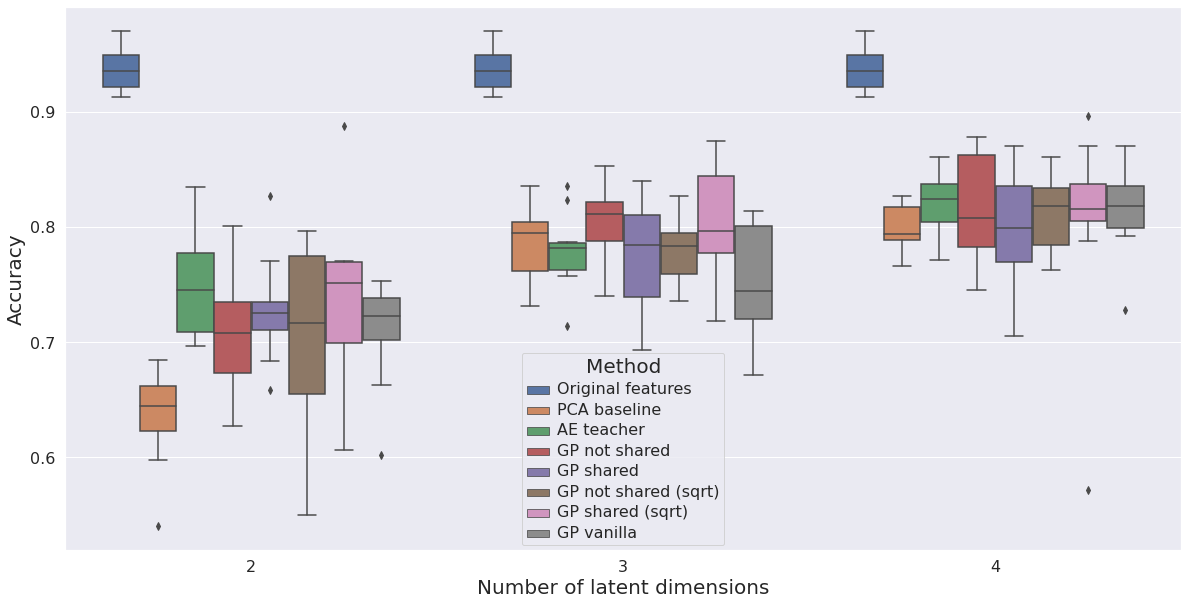

In [108]:
cdf = pd.concat([df1, df2, df3])                              
mdf = pd.melt(cdf, id_vars=['k'], var_name=['Method'])

sns.set_theme()
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="k", y="value", hue="Method", data=mdf)  
ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=16)
ax.set_xticklabels([2, 3, 4], fontsize=16)
ax.set_ylabel("Accuracy", fontsize=20)
ax.set_xlabel("Number of latent dimensions", fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
plt.savefig("boxplot_" + dataset + ".pdf", dpi=600, bbox_inches = 'tight')
plt.show()


# fidelity (mse between the AE and the GP predictions)

In [35]:
def get_output_multi_tree(individual, data_x):
    
    low_dim = []
    
    output = individual.GetOutput(data_x)
    individual_output = np.empty(output.shape)
    for i in range(individual.num_sup_functions):

        scaled_output = individual.sup_functions[i].ls_a + individual.sup_functions[i].ls_b * output[:, i]
        individual_output[:, i] = scaled_output

    low_dim.append(individual_output)
    
    return np.array(low_dim)

In [36]:
def get_output_single_tree(individual, data_x):

    num_latent_dimensions = individual.shape[0]
    low_dim = [[] for _ in range(num_latent_dimensions)]

    for index in range(num_latent_dimensions):

        dim_i_individual = individual[index]

        output = dim_i_individual.GetOutput(data_x)
        output = dim_i_individual.ls_a + dim_i_individual.ls_b * output

        low_dim[index].append(output)

    low_dim = np.array(low_dim)
    
    return np.transpose(low_dim, (1, 2, 0))

In [37]:
def train_base_model(x_data, seed, low_dim=2):
    scaler = StandardScaler()
    scaler = scaler.fit(x_data)
    x_data = scaler.transform(x_data)

    est = nn_autoencoder(seed, x_data.shape[1], low_dim)
    est.fit(x_data, x_data, batch_size=16, epochs=200, verbose=0)

    return est

In [38]:
def get_data_split(dataset, seed):

    split_proportion = [0.6, 0.3, 0.1]
    
    data_x, data_y = load_data(dataset)
    data_x, data_y = shuffle_data(data_x, data_y, seed)

    # data used for the unsupervised/self-supervised DR algorithms
    base_model_data_x = data_x[:int(data_x.shape[0]*split_proportion[0])]

    # data used to train the gp_surrogate model
    gp_surrogate_data_x = data_x[int(data_x.shape[0]*split_proportion[0]):int(data_x.shape[0]*(split_proportion[1]+split_proportion[0]))]

    # data used for testing
    test_data_x = data_x[int((1-split_proportion[2])*data_x.shape[0]):]
    test_data_y = data_y[int((1-split_proportion[2])*data_y.shape[0]):]

    return base_model_data_x, gp_surrogate_data_x, test_data_x, test_data_y

In [30]:
def get_hidden_layers(model, data_x):

    def keras_function_layer(model_layer, data):
        hidden_func = keras.backend.function(model.layers[0].input, model_layer.output)
        result = hidden_func([data.astype('float32')])

        return result

    hidden_layers_list = []
    for index in range(len(model.layers)):
        if isinstance(model.layers[index], keras.layers.convolutional.Conv2D) or isinstance(model.layers[index],
                                                                                            keras.layers.Dense):
            hidden_layer = keras_function_layer(model.layers[index], data_x)
            hidden_layers_list.append(hidden_layer)

    return hidden_layers_list

In [31]:
def nn_autoencoder(seed, input_size, latent_size):
    initializer = keras.initializers.glorot_normal(seed=seed)

    model = keras.models.Sequential([

        keras.layers.Dense(input_size, activation="elu", use_bias=True,
                           trainable=True, kernel_initializer=initializer, input_shape=(input_size,)),

        keras.layers.Dense(int((input_size + latent_size) / 2), activation="elu", use_bias=True,
                           trainable=True, kernel_initializer=initializer),

        keras.layers.Dense(int((input_size + latent_size) / 4), activation="elu", use_bias=True,
                           trainable=True, kernel_initializer=initializer),

        # latent_layer
        keras.layers.Dense(latent_size, activation=keras.activations.linear, use_bias=False,
                           trainable=True, kernel_initializer=initializer),

        keras.layers.Dense(int((input_size + latent_size) / 4), activation="elu", use_bias=True,
                           trainable=True, kernel_initializer=initializer),

        keras.layers.Dense(int((input_size + latent_size) / 2), activation="elu", use_bias=True,
                           trainable=True, kernel_initializer=initializer),

        keras.layers.Dense(input_size, activation=keras.activations.linear, use_bias=False,
                           trainable=True, kernel_initializer=initializer)
    ])

    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='mse', metrics=['mse'])

    return model


In [32]:
dataset = "segmentation"
method = "nn"

In [34]:
list_data = []
list_method_name = []

nn_list_accuracy = []
nn_list_name = []

for num_latent_dimensions in [2, 3, 4]:
    for gp_method in ["not_shared_phi", "shared_phi", "vanilla"]:
    
        path = "gecco/"+dataset+"/"+method+"/"
        file_name = path + "results_" + dataset + "_" + method + "_" + str(num_latent_dimensions)
        file_name = file_name + "_" + gp_method

        results = pickle.load(open(file_name+".p", "rb"))
        print(num_latent_dimensions, gp_method)
        
        list_info = [[] for _ in range(len(results[0].keys()))]

        for index in range(len(results)):

            count = 0
            for k in results[index].keys():
                list_info[count].append(results[index][k])
                count += 1

        if gp_method == "not_shared_phi":
            method_name = "GP not shared"
            
        elif gp_method == "shared_phi":
            method_name = "GP shared"
            
        elif gp_method == "vanilla":
            method_name = "GP vanilla"
            
        list_data.append(list_info[4])
        list_method_name.append(method_name)


2 not_shared_phi
2 shared_phi
2 vanilla
3 not_shared_phi
3 shared_phi
3 vanilla
4 not_shared_phi
4 shared_phi
4 vanilla


In [35]:
meta_error_list = []

count = 1
for num_latent_dimensions in [2, 3, 4]:
    print("COMPUTING FOR NUMBER OF LATENT " + str(num_latent_dimensions))
    for gp_method in ["not_shared_phi", "shared_phi", "vanilla"]:
        
        list_individuals = list_data[count-1]
        error_list = []
        
        for seed in range(10):
            print(seed)

            base_model_data_x, gp_surrogate_data_x, _ = get_data_split(dataset, seed)
            
            scaler = StandardScaler()
            scaler = scaler.fit(gp_surrogate_data_x)
            gp_surrogate_data_x = scaler.transform(gp_surrogate_data_x)
            
            model = train_base_model(base_model_data_x, seed, num_latent_dimensions)
            low_dim_x = get_hidden_layers(model, gp_surrogate_data_x)[3]
            
            if count % 3 == 0:
                gp_output = get_output_single_tree(list_individuals[seed], gp_surrogate_data_x)
            else:
                gp_output = get_output_multi_tree(list_individuals[seed], gp_surrogate_data_x)
            
            squared_error = np.mean(np.power((gp_output[0] - low_dim_x), 2))
            error_list.append(squared_error)
            
            keras.backend.clear_session()
    
        meta_error_list.append(error_list)
        count += 1

COMPUTING FOR NUMBER OF LATENT 2
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
COMPUTING FOR NUMBER OF LATENT 3
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
COMPUTING FOR NUMBER OF LATENT 4
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [36]:
df1 = pd.DataFrame(meta_error_list[:3], index=list_method_name[:3]).T.assign(k=2)
df2 = pd.DataFrame(meta_error_list[3:6], index=list_method_name[3:6]).T.assign(k=3)
df3 = pd.DataFrame(meta_error_list[6:9], index=list_method_name[6:9]).T.assign(k=4)

In [37]:
cdf = pd.concat([df1, df2, df3])                              
mdf = pd.melt(cdf, id_vars=['k'], var_name=['Method'])

/home/thomas/.conda/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


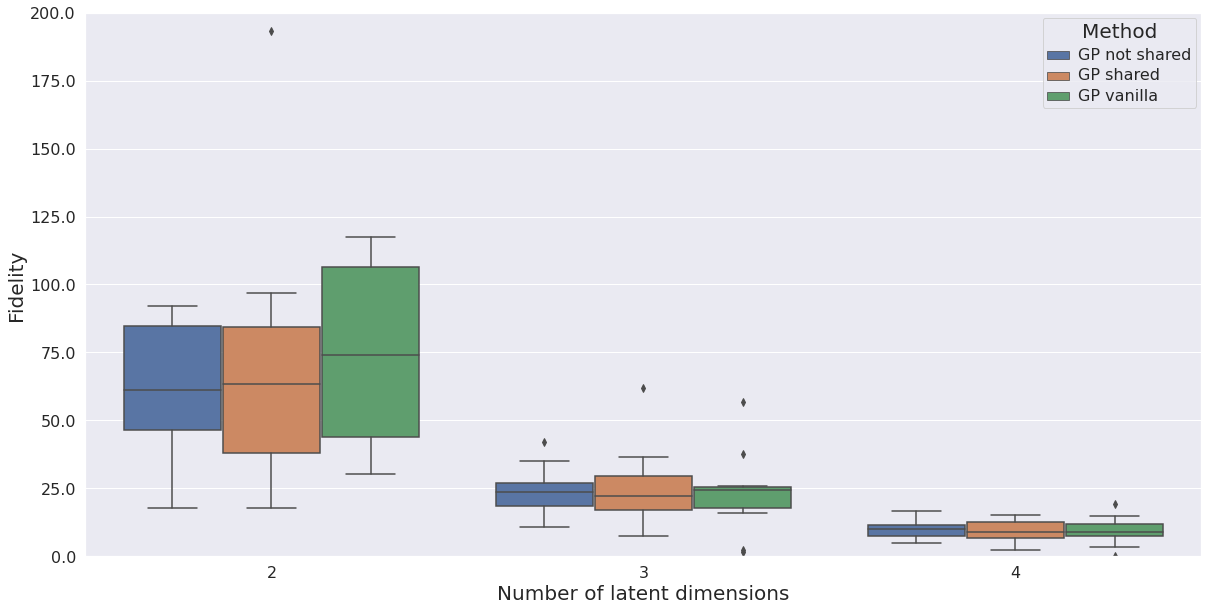

In [39]:
sns.set_theme()
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="k", y="value", hue="Method", data=mdf)  
ax.set(ylim=(0, 200))
ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=16)
ax.set_xticklabels([2, 3, 4], fontsize=16)
ax.set_ylabel("Fidelity", fontsize=20)
ax.set_xlabel("Number of latent dimensions", fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
plt.savefig("fidelity" + dataset + ".pdf", dpi=600, bbox_inches = 'tight')
plt.show()

# test what dataset makes sense

In [33]:
dataset = "observatory"

In [46]:
list_method_names = []
list_data = []

for num_latent_dimensions in [2, 3, 4]: 
    accuracy_list_nn = []
    accuracy_list_pca = []
    accuracy_list_original = []
    
    for run in range(10):
        print(run)

        base_model_data_x, gp_surrogate_data_x, test_data_x, test_data_y = get_data_split(dataset, run)

        scaler = StandardScaler()
        scaler = scaler.fit(base_model_data_x)
        test_data_x = scaler.transform(test_data_x)

        model = train_base_model(base_model_data_x, run, num_latent_dimensions)
        low_dim_x_nn = get_hidden_layers(model, test_data_x)[3]
        
        est = PCA(n_components=num_latent_dimensions)
        est.fit(scaler.transform(base_model_data_x))
        low_dim_x_pca = est.transform(test_data_x)
        
        # nn
        avg_acc_nn, _ = k_fold_valifation_accuracy_rf(low_dim_x_nn, test_data_y, run)
        accuracy_list_nn.append(avg_acc_nn)
        
        # pca
        avg_acc_pca, _ = k_fold_valifation_accuracy_rf(low_dim_x_pca, test_data_y, run)
        accuracy_list_pca.append(avg_acc_pca)
        
        # original dataset
        avg_acc_original, _ = k_fold_valifation_accuracy_rf(test_data_x, test_data_y, run)
        accuracy_list_original.append(avg_acc_original)
    
    list_data.append(accuracy_list_nn)
    list_data.append(accuracy_list_pca)
    list_data.append(accuracy_list_original)
    list_method_names.append("AE teacher")
    list_method_names.append("PCA baseline")
    list_method_names.append("Original features")
    

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [47]:
print(list_method_names)

['AE teacher', 'PCA baseline', 'Original features', 'AE teacher', 'PCA baseline', 'Original features', 'AE teacher', 'PCA baseline', 'Original features']


In [48]:
df1 = pd.DataFrame(list_data[:3], index=list_method_names[:3]).T.assign(k=2)
df2 = pd.DataFrame(list_data[3:6], index=list_method_names[3:6]).T.assign(k=3)
df3 = pd.DataFrame(list_data[6:9], index=list_method_names[6:9]).T.assign(k=4)

/home/thomas/.conda/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


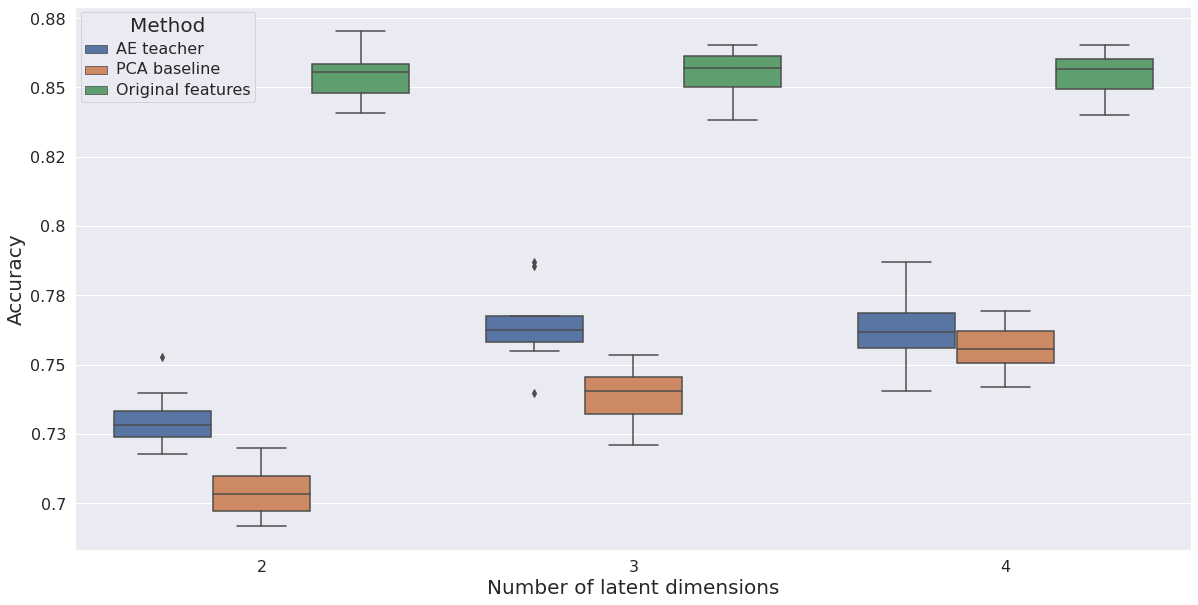

In [49]:
cdf = pd.concat([df1, df2, df3])                              
mdf = pd.melt(cdf, id_vars=['k'], var_name=['Method'])

sns.set_theme()
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="k", y="value", hue="Method", data=mdf)  
ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=16)
ax.set_xticklabels([2, 3, 4], fontsize=16)
ax.set_ylabel("Accuracy", fontsize=20)
ax.set_xlabel("Number of latent dimensions", fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
plt.savefig("boxplot_" + dataset + ".pdf", dpi=600, bbox_inches = 'tight')
plt.show()
